In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import herringbone as hb

All initialization tests passed.
imported herringbone without any errors :)


In [3]:

# map Names
map_names = ["slides", "example", "easy", "danger_holes", "double_fish", "wall_of_death", "example2", "mega"]


# 1. Cumulative Reward

In [4]:
# Build MDP
selected_map_id = 0
state_path = "herringbone/env_core/config/state_config.json"
map_path = f"herringbone/env_core/maps/{map_names[selected_map_id]}.csv"
action_path = "herringbone/env_core/config/action_config.json"

GAMMA = 1

demo_mdp = hb.MDP(state_path, map_path, action_path, seed=42, gamma=GAMMA)

In [5]:
random_policy = hb.Policy(mdp=demo_mdp)
episode = hb.Episode(mdp=demo_mdp, policy=random_policy, max_depth=1000)
episode.peek()


╔═══════╦═══════╦═══════╦═══════╗
║   -1  ║   -1  ║   -1  ║   -1  ║
╠═══════╬═══════╬═══════╬═══════╣
║   -1  ║   -1  ║   -1  ║   -1  ║
╠═══════╬═══════╬═══════╬═══════╣
║   -1  ║   -1  ║   -1  ║   -1  ║
╠═══════╬═══════╬═══════╬═══════╣
║   -1  ║   -1  ║   -1  ║   -1  ║
╚═══════╩═══════╩═══════╩═══════╝[0]


In [6]:
step_size = 1
steps = 100
cumulative_rewards = []
mc_control = hb.MonteCarloController(demo_mdp, epsilon=0.01)
for i in range(steps):
    mc_control.train(n_episodes=step_size)
    episode = hb.Episode(mdp=demo_mdp, policy=mc_control.policy)
    episode.run()
    cumulative_rewards.append(sum(episode.trajectory.rewards[1:]))
    
print(len(cumulative_rewards))

100


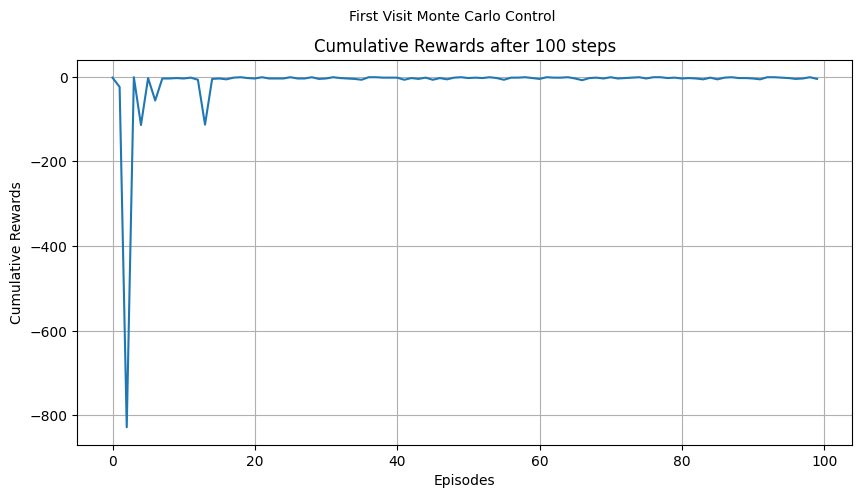

In [7]:
def plot_cumulative_rewards(cumulative_rewards, total_steps):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(cumulative_rewards)), cumulative_rewards, linestyle='-')

    plt.title(f'Cumulative Rewards after {total_steps} steps')
    plt.suptitle('First Visit Monte Carlo Control', fontsize=10)
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.grid(True)
    plt.show()

# Example usage
total_steps = len(cumulative_rewards)
plot_cumulative_rewards(cumulative_rewards, total_steps)

# 2. RMS of value function 

## 2.1. RMS of state-value function

In [8]:
"""Ground truth based on example 4.1. from Andrew Barto en Richard S. Sutton's Reinforcement Learning: An Introduction"""

states = demo_mdp.get_states()
values = [0.0, -14, -20, -22, -14, -18, -20, -20, -20, -20, -18, -14, -22, -20, -14, 0.0]
exact_value_function = dict(zip(states, values))

print(exact_value_function)


{[0, 0]: 0.0, [0, 1]: -14, [0, 2]: -20, [0, 3]: -22, [1, 0]: -14, [1, 1]: -18, [1, 2]: -20, [1, 3]: -20, [2, 0]: -20, [2, 1]: -20, [2, 2]: -18, [2, 3]: -14, [3, 0]: -22, [3, 1]: -20, [3, 2]: -14, [3, 3]: 0.0}


In [9]:
random_policy = hb.Policy(mdp=demo_mdp)

In [10]:
def calc_state_value_rms(truth, predicted):
    y, y_pred = np.array(list(truth.values())), np.array(list(predicted.values()))
    return np.sqrt(np.mean((y - y_pred) ** 2))

In [11]:
step_size = 100
steps = 100
rms_over_time = []
rms_over_time2 = []
mc_predictor = hb.MonteCarloPredictor(demo_mdp)
buh = hb.TDZero(num_episodes=step_size, policy=random_policy, alpha=0.01)
for i in range(steps):
    mc_predictor.evaluate_policy(policy=random_policy,n_samples=step_size)
    rms_over_time.append(calc_state_value_rms(exact_value_function, mc_predictor.value_functions))
    rms_over_time2.append(calc_state_value_rms(exact_value_function, buh.run()))
    



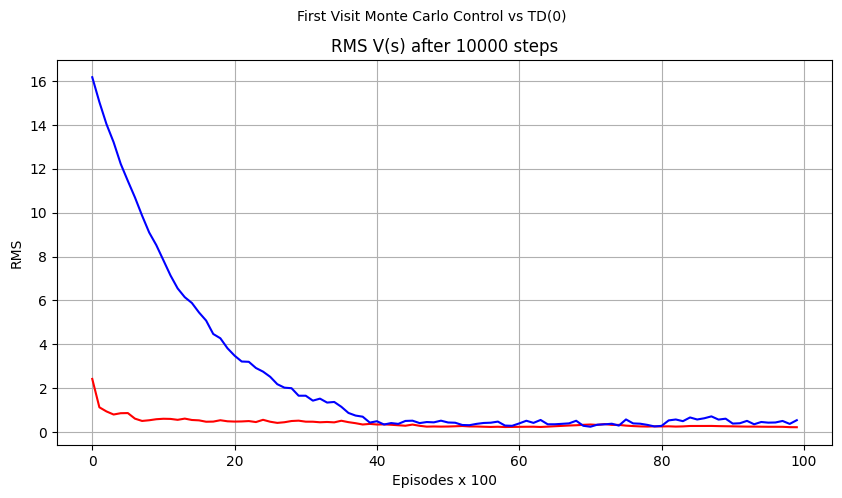

In [12]:
def plot_v_rms(rms, rms2, total_steps):
    plt.figure(figsize=(10, 5))
    # Plot first line with label
    plt.plot(range(len(rms)), rms, linestyle='-', color="red", label="First Visit Monte Carlo Control")
    
    # Plot second line with label
    plt.plot(range(len(rms2)), rms2, linestyle='-', color="blue", label="TD(0)")
    
    plt.title(f'RMS V(s) after {total_steps} steps')
    plt.suptitle('First Visit Monte Carlo Control vs TD(0)', fontsize=10)
    plt.xlabel(f'Episodes x {step_size}')
    plt.ylabel('RMS')

    plt.grid(True)
    plt.show()


plot_v_rms(rms_over_time, rms_over_time2, step_size*steps)

## 2.2. RMS of action-value function

In [13]:
"""Ground truth based on Q-learning """
#TODO replace with Policy Eval
q = hb.QLearning(num_episodes=10_000, mdp=demo_mdp)

q.run()
exact_value_function = q.q_values
exact_value_function

{[0, 0]: {↑: 0.0, ↓: 0.0, ←: 0.0, →: 0.0},
 [0, 1]: {↑: -2.0, ↓: -3.0, ←: -1.0, →: -3.0},
 [0, 2]: {↑: -3.0, ↓: -4.0, ←: -2.0, →: -4.0},
 [0, 3]: {↑: -4.0, ↓: -3.0, ←: -3.0, →: -4.0},
 [1, 0]: {↑: -1.0, ↓: -3.0, ←: -2.0, →: -3.0},
 [1, 1]: {↑: -2.0, ↓: -4.0, ←: -2.0, →: -4.0},
 [1, 2]: {↑: -3.0, ↓: -3.0, ←: -3.0, →: -3.0},
 [1, 3]: {↑: -4.0, ↓: -2.0, ←: -4.0, →: -3.0},
 [2, 0]: {↑: -2.0, ↓: -4.0, ←: -3.0, →: -4.0},
 [2, 1]: {↑: -3.0, ↓: -3.0, ←: -3.0, →: -3.0},
 [2, 2]: {↑: -4.0, ↓: -2.0, ←: -4.0, →: -2.0},
 [2, 3]: {↑: -3.0, ↓: -1.0, ←: -3.0, →: -2.0},
 [3, 0]: {↑: -3.0, ↓: -4.0, ←: -4.0, →: -3.0},
 [3, 1]: {↑: -4.0, ↓: -3.0, ←: -4.0, →: -2.0},
 [3, 2]: {↑: -3.0, ↓: -2.0, ←: -3.0, →: -1.0},
 [3, 3]: {↑: 0.0, ↓: 0.0, ←: 0.0, →: 0.0}}

In [28]:
def calc_action_value_rms(truth, predicted):
    y = np.asarray([list(q.values()) for q in truth.values()])
    y_pred = np.asarray([list(q.values()) for q in predicted.values()])
    # Calculate RMS error for each Q(s,a)
    rms_per_q = np.sqrt(np.mean((y - y_pred) ** 2, axis=1))
    # Calculate the mean of the RMS errors
    return np.mean(rms_per_q)

In [ ]:
step_size = 100
steps = 100

rms_over_time = []
rms_over_time2 = []
rms_over_time3 = []

mc_controller = hb.MonteCarloController(demo_mdp, 0.25)
s = hb.Sarsa(num_episodes=step_size, mdp=demo_mdp)
q = hb.QLearning(num_episodes=step_size, mdp=demo_mdp)

for i in range(steps):
    mc_controller.train(step_size)

    rms_over_time.append(calc_action_value_rms(exact_value_function,  mc_controller.q_values))
    rms_over_time2.append(calc_action_value_rms(exact_value_function, s.run()))
    rms_over_time3.append(calc_action_value_rms(exact_value_function, q.run()))
    



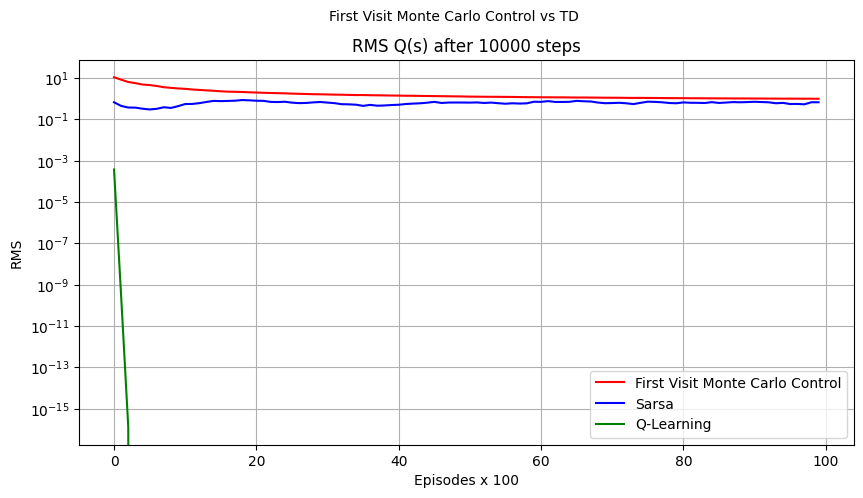

In [ ]:
def plot_q_rms(rms, rms2,rms3, total_steps):
    plt.figure(figsize=(10, 5))
 
    plt.plot(range(len(rms)), rms, linestyle='-', color="red", label="First Visit Monte Carlo Control")

    plt.plot(range(len(rms2)), rms2, linestyle='-', color="blue", label="Sarsa")

    plt.plot(range(len(rms3)), rms3, linestyle='-', color="green", label="Q-Learning")
    
    plt.title(f'RMS V(s) after {total_steps} steps')
    plt.suptitle('First Visit Monte Carlo Control vs TD', fontsize=10)
    plt.xlabel(f'Episodes x {step_size}')
    plt.ylabel('RMS')

    plt.grid(True)
    plt.legend()
    plt.show()


plot_q_rms(rms_over_time, rms_over_time2,  rms_over_time3, step_size*steps)